<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
Applied ML · MLOps · Production
<br>
Join 30K+ developers in learning how to responsibly <a href="https://madewithml.com/about/">deliver value</a> with ML.
    <br>
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-30K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/Made-With-ML"><img src="https://img.shields.io/github/stars/GokuMohandas/Made-With-ML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/topics/deep-learning" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

# Logistic Regression

In this lesson, we're going to implement logistic regression for a classification task where we want to probabilistically determine the outcome for a given set of inputs. We will understand the basic math behind it, implement it in just NumPy and then in PyTorch.

<div align="left">
<a target="_blank" href="https://madewithml.com/courses/foundations/logistic-regression/"><img src="https://img.shields.io/badge/📖 Read-blog post-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/07_Logistic_Regression.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/Made-With-ML/blob/main/notebooks/07_Logistic_Regression.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Overview

Logistic regression is an extension on linear regression (both are generalized linear methods). We will still learn to model a line (plane) that models $y$ given $X$. Except now we are dealing with classification problems as opposed to regression problems so we'll be predicting probability distributions as opposed to a discrete value. We'll be using the softmax operation to normalize our logits ($XW$) to derive probabilities.

Our goal is to learn a logistic model $\hat{y}$ that models $y$ given $X$. 

$ \hat{y} = \frac{e^{XW_y}}{\sum_j e^{XW}} $ 
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DXC}$ ($C$ is the number of classes)
* bias term ($b$) excluded to avoid crowding the notations


This function is known as the multinomial logistic regression or the softmax classifier. The softmax classifier will use the linear equation ($z=XW$) and normalize it (using the softmax function) to produce the probability for class y given the inputs.

* **Objective:**  Predict the probability of class $y$ given the inputs $X$. The softmax classifier normalizes the linear outputs to determine class probabilities. 
* **Advantages:**
  * Can predict class probabilities given a set on inputs.
* **Disadvantages:**
  * Sensitive to outliers since objective is to minimize cross entropy loss. Support vector machines (SVMs) are a good alternative to counter outliers.
* **Miscellaneous:** Softmax classifier is going to used widely in neural network architectures as the last layer since it produces class probabilities.

# Set up

In [1]:
import numpy as np
import random

In [2]:
SEED = 1234

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

## Load data

We'll used some synthesized data to train our models on. The task is to determine whether a tumor will be benign (harmless) or malignant (harmful) based on leukocyte (white blood cells) count and blood pressure. Note that this is a synthetic dataset that has no clinical relevance.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [5]:
# Read from CSV to Pandas DataFrame
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [6]:
# Define X and y
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values

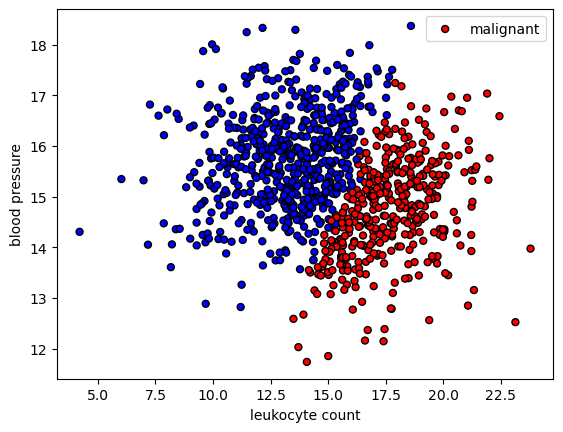

In [8]:
# Plot data
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()

## Split data

We want to split our dataset so that each of the three splits has the same distribution of classes so that we can train and evaluate properly. We can easily achieve this by telling scikit-learn's [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function what to `stratify` on. 

In [9]:
import collections
from sklearn.model_selection import train_test_split

In [10]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [11]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [12]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


Now let's see how many samples per class each data split has:

In [13]:
# Overall class distribution
class_counts = dict(collections.Counter(y))
print (f"Classes: {class_counts}")
print (f'm:b = {class_counts["malignant"]/class_counts["benign"]:.2f}')

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [16]:
# Per data split class distribution
train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))
print (f"train m:b = {train_class_counts['malignant']/train_class_counts['benign']:.2f}")
print (f"val m:b = {val_class_counts['malignant']/val_class_counts['benign']:.2f}")
print (f"test m:b = {test_class_counts['malignant']/test_class_counts['benign']:.2f}")

train m:b = 1.57
val m:b = 1.54
test m:b = 1.59


## Label encoding

You'll notice that our class labels are text. We need to encode them into integers so we can use them in our models. We could scikit-learn's [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) to do this but we're going to write our own simple label encoder class so we can see what's happening under the hood. 

In [17]:
import itertools

In [18]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [19]:
# Fit
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'benign': 0, 'malignant': 1}

In [20]:
# Encoder
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")
print (f"decoded: {label_encoder.decode([y_train[0]])}")

y_train[0]: malignant
y_train[0]: 1
decoded: ['malignant']


We also want to calculate our class weights, which are useful for weighting the loss function during training. It tells the model to focus on samples from an under-represented class. The loss section below will show how to incorporate these weights.

In [21]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


## Standardize data

We need to standardize our data (zero mean and unit variance) so a specific feature's magnitude doesn't affect how the model learns its weights. We're only going to standardize the inputs X because our outputs y are class values.

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [24]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [25]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


# NumPy

Now that we have our data prepared, we'll first implement logistic regression using just NumPy. This will let us really understand the underlying operations. It's normal to find the math and code in this section slightly complex. You can still read each of the steps to build intuition for when we implement this using PyTorch.

Our goal is to learn a logistic model $\hat{y}$ that models $y$ given $X$. 

$ \hat{y} = \frac{e^{XW_y}}{\sum e^{XW}} $ 
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DXC}$ ($C$ is the number of classes)

> We are going to use multinomial logistic regression even though our task only involves two classes because you can generalize the softmax classifier to any number of classes.

## Initialize weights

1. Randomly initialize the model's weights $W$.

In [26]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
NUM_CLASSES = len(label_encoder.classes) # y has two possibilities (benign or malignant)

In [27]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


## Model

2. Feed inputs $X$ into the model to receive the logits ($z=XW$). Apply the softmax operation on the logits to get the class probabilies $\hat{y}$ in one-hot encoded form. For example, if there are three classes, the predicted class probabilities could look like [0.3, 0.3, 0.4]. 
  * $ \hat{y} = softmax(z) = softmax(XW) = \frac{e^{XW_y}}{\sum_j e^{XW}} $

In [28]:
# Forward pass [NX2] · [2X2] + [1,2] = [NX2]
logits = np.dot(X_train, W) + b
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (700, 2)
sample: [-0.0069945   0.00647147]


In [29]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (700, 2)
sample: [0.49663356 0.50336644]


## Loss

 3. Compare the predictions $\hat{y}$ (ex.  [0.3, 0.3, 0.4]) with the actual target values $y$ (ex. class 2 would look like [0, 0, 1]) with the objective (cost) function to determine loss $J$. A common objective function for logistics regression is cross-entropy loss. 

  * $J(\theta) = - \sum_i ln(\hat{y_i}) = - \sum_i ln (\frac{e^{X_iW_y}}{\sum_j e^{X_iW}}) $

In [30]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")

loss: 0.70


## Gradients

4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights. Let's assume that our classes are mutually exclusive (a set of inputs could only belong to one class).
 * $\frac{\partial{J}}{\partial{W_j}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_j}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_j}} = - \frac{1}{\frac{e^{XW_y}}{\sum_j e^{XW}}}\frac{\sum_j e^{XW}e^{XW_y}0 - e^{XW_y}e^{XW_j}X}{(\sum_j e^{XW})^2} = \frac{Xe^{XW_j}}{\sum_j e^{XW}} = X\hat{y}$
  * $\frac{\partial{J}}{\partial{W_y}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_y}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_y}} = - \frac{1}{\frac{e^{XW_y}}{\sum_j e^{XW}}}\frac{\sum_j e^{XW}e^{XW_y}X - e^{W_yX}e^{XW_y}X}{(\sum_j e^{XW})^2} = \frac{1}{\hat{y}}(X\hat{y} - X\hat{y}^2) = X(\hat{y}-1)$

In [31]:
# Backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)

## Update weights

5. Update the weights $ W $  using a small learning rate $ \alpha $. The updates will penalize the probability for the incorrect classes (j) and encourage a higher probability for the correct class (y).
  * $W_j = W_j - \alpha\frac{\partial{J}}{\partial{W_j}}$

In [32]:
LEARNING_RATE = 1e-1

In [33]:
# Update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

## Training

6. Repeat steps 2 - 5 to minimize the loss and train the model.

In [34]:
NUM_EPOCHS = 50

In [35]:
# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))

In [38]:
# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX2] · [2X2] = [NX2]
    logits = np.dot(X_train, W) + b
    
    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%10 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # Backpropagation
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW = np.dot(X_train.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db

Epoch: 0, loss: 0.177, accuracy: 0.977
Epoch: 10, loss: 0.170, accuracy: 0.977
Epoch: 20, loss: 0.164, accuracy: 0.977
Epoch: 30, loss: 0.158, accuracy: 0.979
Epoch: 40, loss: 0.153, accuracy: 0.979


## Evaluation

Now we're ready to evaluate our trained model on our test (hold-out) data split.

In [39]:
class LogisticRegressionFromScratch():
    def predict(self, x):
        logits = np.dot(x, W) + b
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

In [40]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)

In [41]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.98


In [42]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")

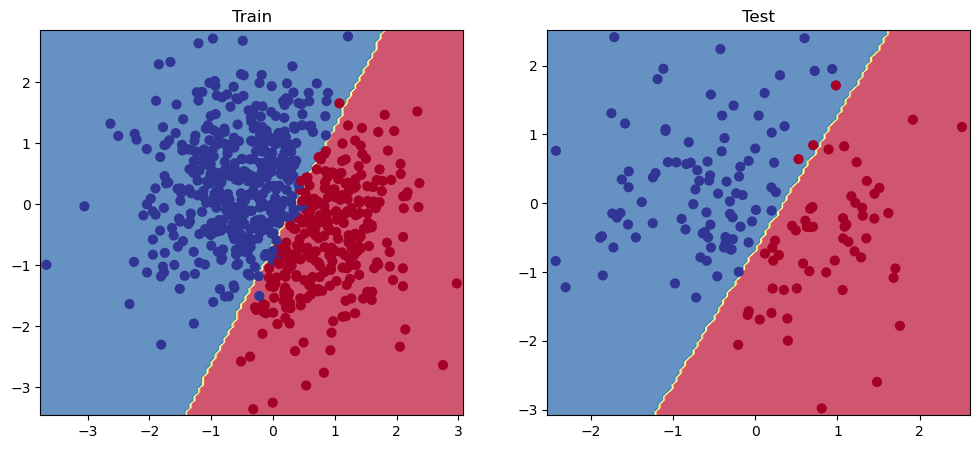

In [43]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

# PyTorch

Now that we've implemented logistic regression with Numpy, let's do the same with PyTorch. 

In [44]:
import torch

In [45]:
# Set seed for reproducibility
torch.manual_seed(SEED)

## Model

We will be using [Linear layers](https://pytorch.org/docs/stable/nn.html#linear-layers)  to recreate the same model.

In [46]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [47]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        y_pred = self.fc1(x_in)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [48]:
# Initialize model
model = LogisticRegression(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of LogisticRegression(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


## Loss

Our loss will be the categorical [crossentropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss). 

In [49]:
loss_fn = nn.CrossEntropyLoss()
y_pred = torch.randn(3, NUM_CLASSES, requires_grad=False)
y_true = torch.empty(3, dtype=torch.long).random_(NUM_CLASSES)
print (y_true)
loss = loss_fn(y_pred, y_true)
print(f"Loss: {loss.numpy()}")

tensor([0, 0, 0])
Loss: 1.2779091596603394


In our case, we will also incorporate the class weights into our loss function to counter any class imbalances.

In [50]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

## Metrics

We'll compute accuracy as we train our model because just looking the loss value isn't super intuitive to look at. We'll look at other metrics (precision, recall, f1) in the evaluation section below.

In [51]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [52]:
y_pred = torch.Tensor([0, 0, 1])
y_true = torch.Tensor([1, 1, 1])
print(f"Accuracy: {accuracy_fn(y_pred, y_true):.1f}")

Accuracy: 33.3


## Optimizer

We'll be sticking with our Adam optimizer from previous lessons.

In [53]:
from torch.optim import Adam

In [54]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

## Training

In [55]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [56]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.96, accuracy: 60.7
Epoch: 10 | loss: 0.28, accuracy: 87.0
Epoch: 20 | loss: 0.15, accuracy: 95.6
Epoch: 30 | loss: 0.12, accuracy: 97.7
Epoch: 40 | loss: 0.10, accuracy: 98.3


## Evaluation

First let's see the accuracy of our model on our test split.

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.0449, 0.9551], grad_fn=<SelectBackward0>)
sample class: 1


In [59]:
# Accuracy (could've also used our own accuracy function)
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.98


We can also evaluate our model on other meaningful metrics such as precision and recall. These are especially useful when there is data imbalance present.

$\text{accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$ 

$\text{recall} = \frac{TP}{TP+FN}$ → (how many of the actual issues did I catch)

$\text{precision} = \frac{TP}{TP+FP}$ → (out of all the things I said were issues, how many were actually issues)

$F_1 = 2 * \frac{\text{precision }  *  \text{ recall}}{\text{precision } + \text{ recall}}$

where: 
* TP: # of samples truly predicted to be positive and were positive
* TN: # of samples truly predicted to be negative and were negative
* FP: # of samples falsely predicted to be positive but were negative
* FN: # of samples falsely predicted to be negative but were positive

In [60]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [61]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [62]:
# Performance
performance = get_performance(y_true=y_test, y_pred=pred_test, classes=label_encoder.classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9800264101112998,
    "recall": 0.98,
    "f1": 0.9799670975323149,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 0.9824561403508771,
      "recall": 0.9655172413793104,
      "f1": 0.9739130434782608,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.978494623655914,
      "recall": 0.9891304347826086,
      "f1": 0.9837837837837837,
      "num_samples": 92.0
    }
  }
}


With logistic regression (extension of linear regression), the model creates a linear decision boundary that we can easily visualize.

In [64]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

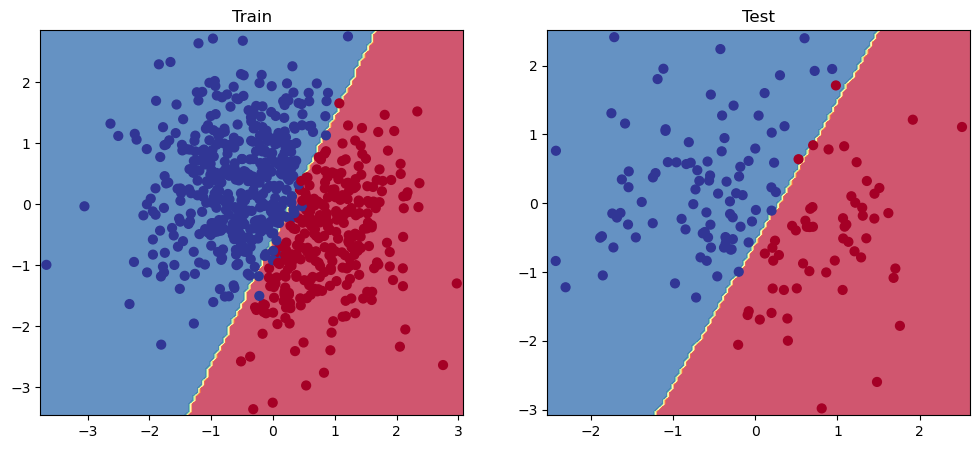

In [65]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

## Inference

In [66]:
# Inputs for inference
X_infer = pd.DataFrame([{"leukocyte_count": 13, "blood_pressure": 12}])
X_infer.head()

,leukocyte_count,blood_pressure
0,13,12


In [67]:
# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)

[[-0.68505296 -3.11487099]]


c:\Users\l.dubreil\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [68]:
# Predict
y_infer = model(torch.Tensor(X_infer), apply_softmax=True)
prob, _class = y_infer.max(dim=1)
label = label_encoder.decode(_class.detach().numpy())[0]
print (f"The probability that you have a {label} tumor is {prob.detach().numpy()[0]*100.0:.0f}%")

The probability that you have a benign tumor is 93%


# Unscaled weights

Note that only X was standardized.

$\hat{y}_{unscaled} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}x_{{scaled}_j}$
* $x_{scaled} = \frac{x_j - \bar{x}_j}{\sigma_j}$

$\hat{y}_{unscaled} = b_{scaled} + \sum_{j=1}^{k} W_{{scaled}_j} (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y}_{unscaled} = (b_{scaled} - \sum_{j=1}^{k} W_{{scaled}_j}\frac{\bar{x}_j}{\sigma_j}) +  \sum_{j=1}^{k} (\frac{W_{{scaled}_j}}{\sigma_j})x_j$

In the expression above, we can see the expression $\hat{y}_{unscaled} = W_{unscaled}x + b_{unscaled} $, therefore:

* $W_{unscaled} = \sum_{j=1}^{k} (\frac{W_{{scaled}_j}}{\sigma_j}) $

* $b_{unscaled} = b_{scaled} - \sum_{j=1}^{k} W_{{scaled}_j}\frac{\bar{x}_j}{\sigma_j}$

In [69]:
# Unstandardize weights 
W = model.fc1.weight.data.numpy()
b = model.fc1.bias.data.numpy()
W_unscaled = W / X_scaler.scale_
b_unscaled = b - np.sum((W_unscaled * X_scaler.mean_))
print (W_unscaled)
print (b_unscaled)

[[ 0.61299719 -1.18550914]
 [-0.95371052  0.88432882]]
[ 8.929324 10.233843]
